# Hot Dog Not Hot Dog Dataset

### The meme dataset from HBO show _Silicon Valley_. This dataset has images of hot dogs and not hot dogs.

#### Dataset URL: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog (49MB)

#### Code Reference: https://www.kaggle.com/dansbecker/exercise-tensorflow-programming and the _Cat, Dog, Wolf Transfer learning_ Notebook (Question 2)

##### Joseph Notes:
I will use transfer learning to determine if something is a hot dog or not. The code refernce listed above uses a neural network built from the ground up, but I will use it as a referemce because I am not a ML master.

##### Notes:
This notebook requires a kaggle account

##### Rerfence:

[Transfer Learning (C3W2L07)](https://www.youtube.com/watch?v=yofjFQddwHE)

[11. Transfer Learning for Domain-Specific Image Classification with Small Datasets](https://www.youtube.com/watch?v=vbhEnEbj3JM)

[Transfer Learning](https://www.youtube.com/watch?v=Ui1KbmutX0k)


In [1]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-b3420b31-4832-b27f-df3a-6215a94894aa)


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tf.__version__)
print(device_lib.list_local_devices())

Num GPUs Available:  1
Tensorflow version: 2.5.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 543360636331048966
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9392422912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9669224998841970177
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0b:00.0, compute capability: 7.5"
]


In [3]:
# If in colab
if "google.colab" in str(get_ipython()):
    %tensorflow_version 2.x  # Uncomment for colab

import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


%matplotlib inline
print("Import Success!")

Import Success!


In [4]:
# !pip install opendatasets

URL = 'https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/download'
DIR = 'hot-dog-not-hot-dog'

# Download dataset
if not os.path.exists(DIR):
    """
    Reference:
        How to Download Kaggle Datasets using Jupyter Notebook
            Reference:
                https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/
    """
    import opendatasets as od

    od.download(URL)

In [5]:
# """
# Unzip files if they don't exist
# """
# if not os.path.exists("ZIP_NAME_OUTPUT"):
#     """
#     Reference:
#         Unzipping files in Python
#             https://stackoverflow.com/questions/3451111/unzipping-files-in-python
#     """
#     import zipfile

#     with zipfile.ZipFile(ZIP_NAME_OUTPUT, 'r') as zip_ref:
#         zip_ref.extractall(os.getcwd())

#     print("Done.")

In [6]:
"""
Setting up the paths to the data

Notes:
    
"""

path_train = DIR + "/train"
path_test = DIR + "/test"

print("Paths Loaded.")

Paths Loaded.


In [7]:
# Settings
SEED = 24
BATCH_SIZE_TRAIN = 12
BATCH_SIZE_VALIDATION = 12
BATCH_SIZE_TEST = 12

## Load datasets

In [8]:
image_size = (224, 224)  # This is the resolution that the vgg16 model takes in
classes = ['hot_dog', 'not_hot_dog']  # Classes from the dataset (Names of the folder in a path that contains teh data)

train_datagen = ImageDataGenerator(
    validation_split=0.0,  # set validation split
)

batches_train = train_datagen.flow_from_directory(
    path_train,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_TRAIN,
    subset='training',
    seed=SEED
)

batches_validation = train_datagen.flow_from_directory(
    path_train,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_VALIDATION,
    subset='validation',
    seed=SEED
)

batches_test = ImageDataGenerator().flow_from_directory(
    path_test,
    image_size,
    classes=classes,
    batch_size=BATCH_SIZE_TEST,
    seed=SEED

)

Found 498 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [9]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):

    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0, 2, 3, 1))

    f = plt.figure(figsize=figsize)

    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1

    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)

        # plt.figure(figsize=(12,))
        plt.imshow(ims[i], interpolation=None if interp else "none")

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


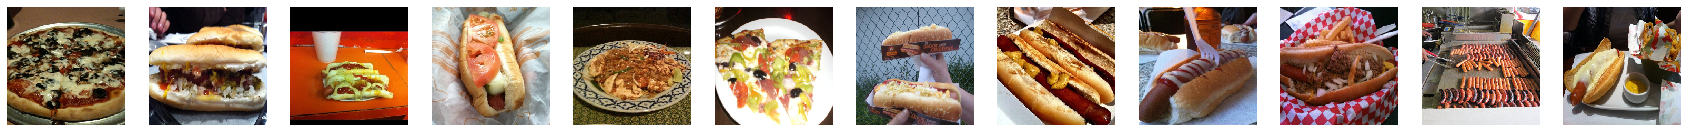

In [10]:
test_imgs, test_labels = next(batches_test)

plots(test_imgs, figsize=(30, 15))
print(test_labels)

## Load vgg16 model

In [11]:
model_vgg16 = tensorflow.keras.applications.VGG16()

## Create a new model that is pretrained using vgg16 model and then fined tuned with the hot dog not hot dog dataset (Transfer Learning)

In [12]:

model_transfer_learned = Sequential()

# Copy every layer except the last layer of the vgg16 model
for layer in model_vgg16.layers[:-1]:
    model_transfer_learned.add(layer)

"""
Set the layers in the new model to not trainable

Notes:
    Recall that layers be default are trainable
    Retraining the last 2 layers, fc1 and fc2, is not a good idea unless you have a lot of data
"""
for layer in model_transfer_learned.layers:
    layer.trainable = False


# model_transfer_learned.layers[0].trainable = True
# model_transfer_learned.layers[1].trainable = True
# model_transfer_learned.layers[2].trainable = True

# Additional layer if needed
# model_transfer_learned.add(Dense(2048,
#                                  activation='elu',
#                                  # activity_regularizer=regularizers.l2(.05)  # Regularization seems like a bad idea since we still don't get good results
#                                  )
#                            )

# model_transfer_learned.add(Dense(4096,
#                                  activation='elu',
#                                  # activity_regularizer=regularizers.l2(.05)  # Regularization seems like a bad idea since we still don't get good results
#                                  )
#                            )


# Add a new dense layer (This layer will be trained)
model_transfer_learned.add(Dense(len(classes), activation='softmax'))


for layer in model_transfer_learned.layers:
    print("{:<20}{:<10}{:<70}{}".format(layer.name,
                                        str(layer.get_config().get('activation')),
                                        str(layer.get_config().get('activity_regularizer')),
                                        layer.trainable)
          )

model_transfer_learned.summary()

block1_conv1        relu      None                                                                  False
block1_conv2        relu      None                                                                  False
block1_pool         None      None                                                                  False
block2_conv1        relu      None                                                                  False
block2_conv2        relu      None                                                                  False
block2_pool         None      None                                                                  False
block3_conv1        relu      None                                                                  False
block3_conv2        relu      None                                                                  False
block3_conv3        relu      None                                                                  False
block3_pool         None      None            

## Compile Model

In [13]:
model_transfer_learned.compile(
    Adam(learning_rate=.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),  # Hotdog Not Hotdog is a binary problem!
    # loss=tf.keras.losses.CategoricalCrossentropy,
    metrics=['accuracy']
)
print("Done")

Done


## Train the model

In [14]:
%timeit

model_transfer_learned.fit(
    batches_train,
    validation_data=batches_validation,
    steps_per_epoch=batches_train.samples // BATCH_SIZE_TRAIN,
    validation_steps=batches_validation.samples // BATCH_SIZE_VALIDATION,
    epochs=100,
    verbose=1
)

print("Trining Complete!")

Epoch 1/100
41/41 [==============================] - 5s 49ms/step - loss: 0.7503 - accuracy: 0.6790
Epoch 2/100
41/41 [==============================] - 1s 33ms/step - loss: 0.5620 - accuracy: 0.7881
Epoch 3/100
41/41 [==============================] - 1s 33ms/step - loss: 0.4726 - accuracy: 0.8251
Epoch 4/100
41/41 [==============================] - 1s 33ms/step - loss: 0.4175 - accuracy: 0.8374
Epoch 5/100
41/41 [==============================] - 1s 33ms/step - loss: 0.3826 - accuracy: 0.8477
Epoch 6/100
41/41 [==============================] - 1s 33ms/step - loss: 0.3430 - accuracy: 0.8663
Epoch 7/100
41/41 [==============================] - 1s 33ms/step - loss: 0.3257 - accuracy: 0.8827
Epoch 8/100
41/41 [==============================] - 1s 34ms/step - loss: 0.3058 - accuracy: 0.8971
Epoch 9/100
41/41 [==============================] - 1s 34ms/step - loss: 0.2893 - accuracy: 0.9012
Epoch 10/100
41/41 [==============================] - 1s 33ms/step - loss: 0.2672 - accuracy: 0.9053

# Evaluating the model

In [15]:
test_loss, test_acc = model_transfer_learned.evaluate(
    batches_test,
    steps=len(batches_test),
    verbose=1
)
print(test_loss)
print(test_acc)

42/42 [==============================] - 2s 50ms/step - loss: 0.4334 - accuracy: 0.8560
0.4334237575531006
0.8560000061988831


# Predicting with the model

In [16]:
predictions = model_transfer_learned.predict(
    batches_test,
    steps=len(batches_test),  # This will get all batches
    verbose=1
)

42/42 [==============================] - 1s 32ms/step


In [17]:
pd.concat(
    [
        pd.DataFrame(predictions.argmax(axis=1), columns=["Predictions"]),
        pd.DataFrame(batches_test.classes, columns=["True"])
    ],
    axis=1
)

,Predictions,True
0,1,0
1,1,0
2,1,0
3,0,0
4,1,0
...,...,...
495,0,1
496,1,1
497,1,1
498,1,1


In [18]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + "_hot_dog_not_hot_dog")

# Confunsion Matrix Stuff

In [19]:
cm = confusion_matrix(
    y_true=batches_test.classes,
    y_pred=predictions.argmax(axis=1),
)

display(cm)

array([[124, 126],
       [116, 134]], dtype=int64)

Confusion matrix, without normalization
[[124 126]
 [116 134]]


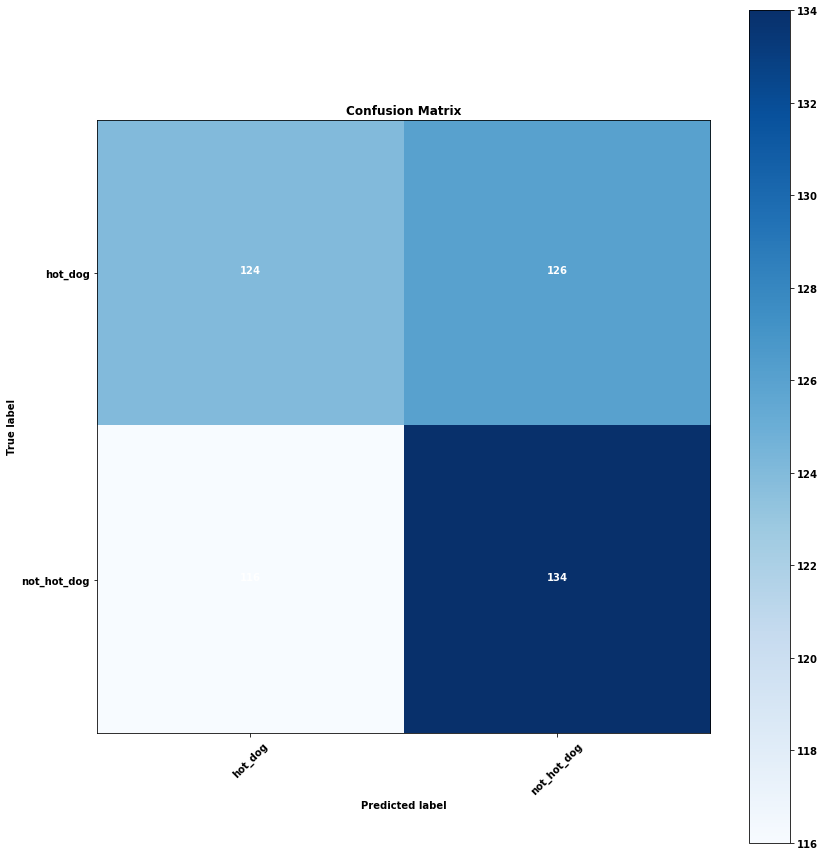

In [20]:
plot_confusion_matrix(cm=cm,
                      classes=classes,
                      title="Confusion Matrix")

In [21]:
def save_best_model(path_abs_model, model_given, test_batches_given, steps, optimzier=Adam(learning_rate=.0001), loss='categorical_crossentropy', metricts=['accuracy']):

    import tensorflow as tf
    import os

    model_given_test_loss, model_given_test_acc = model_given.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save if there is no model to compare to
    if not os.path.exists(path_abs_model):
        print(f"Current model with acc ({model_given_test_acc}) is saved!")
        model_given.save(path_abs_model)
        return

    model_existing = tf.keras.models.clone_model(model_given)
    model_existing.load_weights(path_abs_model)

    model_existing.compile(optimzier,
                           loss=loss,
                           metrics=metricts)

    model_existing_test_loss, model_existing_test_acc = model_existing.evaluate(
        test_batches_given,
        steps=steps,
        verbose=1
    )

    # Save model given if it's better than the existing one
    if model_given_test_acc >= model_existing_test_acc:
        print(
            f"Current model with acc ({model_given_test_acc}) is better than Existing model with acc ({model_existing_test_acc}) and is saved!")
        model_existing.save(path_abs_model)

    else:
        print(
            f"Existing model with acc ({model_existing_test_acc}) is better than Current model with acc ({model_given_test_acc})")

In [22]:
# save_best_model(
#     'weights_hot_dog_not_hot_dog_VGG16_fine_tuned.h5',
#     model_transfer_learned,
#     batches_test,
#     len(batches_test),
#     loss = tf.keras.losses.BinaryCrossentropy()
# )

In [23]:
# model.load_weights('weights_hot_dog_not_hot_dog_VGG16_fine_tuned.h5')
# print("Model Loaded.")

# Conclusion

### It is hard to predict if an image is a hot dog or not a hot dog using a fine tuned vgg16 model with the dataset that I downloaded.